# Step1: Scrape Real-world Dataset

The data used in this report comes from the CoinGecko website through its public API. CoinGecko is the world’s largest independent cryptocurrency data aggregator, integrating data from more than 1,000 crypto exchanges and listing over 18,000 coins across 600+ categories.

For this report, I collected the following variables of interest within a one-year time range: date, price, market_cap, volume_24h, coin_id, coin_name, and category. These data were obtained by programmatically accessing CoinGecko’s API endpoints and retrieving the relevant market information for each selected cryptocurrency.

In [2]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal,levene

In [ ]:
# CoinGecko API Configuration
API_KEY = "CG-o6J3GwRFpBWgZVkBb7ceMeLc" # create a API key from the CoinGecko website
BASE_URL = "https://api.coingecko.com/api/v3"

# Define categories to fetch
CATEGORIES = {
    'Layer 1': 'layer-1',
    'DeFi': 'decentralized-finance-defi',
    'GameFi': 'gaming'
}

# Define time range: past 1 year
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=365)  # Past 1 year, this is the limit of free regualr users

print(f"Time range: {START_DATE.strftime('%Y-%m-%d')} to {END_DATE.strftime('%Y-%m-%d')} (past 1 year)")

def get_category_data(category_id, api_key):
    """
    Fetch current data for top 10 coins by market cap in the specified category
    """
    url = f"{BASE_URL}/coins/markets"
    params = {
        'vs_currency': 'usd',
        'category': category_id,
        'order': 'market_cap_desc',
        'per_page': 10,  # Fetch top 10 coins by market cap
        'page': 1,
        'sparkline': False
    }
    
    headers = {
        'x-cg-demo-api-key': api_key
    }
    
    try:
        response = requests.get(url, params=params, headers=headers)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error: Status code {response.status_code}")
            print(f"Response content: {response.text[:500]}")
            return None
    except Exception as e:
        print(f"Request failed: {e}")
        return None

def get_historical_data(coin_id, start_date, end_date, api_key):
    """
    Fetch historical data for the specified coin (past 1 year)
    """
    url = f"{BASE_URL}/coins/{coin_id}/market_chart/range"
    params = {
        'vs_currency': 'usd',
        'from': int(start_date.timestamp()),
        'to': int(end_date.timestamp())
    }
    
    headers = {
        'x-cg-demo-api-key': api_key
    }
    
    try:
        response = requests.get(url, params=params, headers=headers)
        if response.status_code == 200:
            return response.json()

    except Exception as e:
        print(f"  Failed to fetch historical data for {coin_id}: {e}")
        return None

# Store all raw data
all_current_data = {}
all_historical_data = {}

print("="*80)
print("Starting to download raw data (past 1 year)")
print(f"Time range: {START_DATE.strftime('%Y-%m-%d')} to {END_DATE.strftime('%Y-%m-%d')}")
print("="*80)

# Fetch data for each category
for category_name, category_id in CATEGORIES.items():
    print(f"\n【{category_name} Category】")
    
    # 1. Fetch current data (top 10 coins by market cap)
    print(f"Fetching current data for {category_name} category (top 10 coins by market cap)...")
    current_data = get_category_data(category_id, API_KEY)
    
    if not current_data or len(current_data) == 0:
        print(f"No data retrieved for {category_name} category")
        continue
    
    # Save current data as DataFrame
    current_df = pd.DataFrame(current_data)
    all_current_data[category_name] = current_df
    print(f"✓ Successfully retrieved current data for {len(current_df)} coins")
    
    # 2. Fetch historical data for each coin
    coin_ids = current_df['id'].tolist()
    coin_names = current_df['name'].tolist()
    
    print(f"Fetching historical data for top 10 coins in {category_name} category (past 1 year)...")
    category_historical_data = []
    
    for i, (coin_id, coin_name) in enumerate(zip(coin_ids, coin_names), 1):
        print(f"  [{i}/10] Fetching historical data for {coin_name} ({coin_id})...")
        historical_data = get_historical_data(coin_id, START_DATE, END_DATE, API_KEY)
        
        if historical_data:
            prices = historical_data.get('prices', [])
            market_caps = historical_data.get('market_caps', [])
            total_volumes = historical_data.get('total_volumes', [])
            
            if prices:
                hist_df = pd.DataFrame({
                    'timestamp': [p[0] for p in prices],
                    'date': pd.to_datetime([p[0] for p in prices], unit='ms'),
                    'price': [p[1] for p in prices],
                    'market_cap': [mc[1] if mc and len(mc) > 1 and mc[1] else None for mc in market_caps] if market_caps else [None] * len(prices),
                    'volume_24h': [tv[1] if tv and len(tv) > 1 and tv[1] else None for tv in total_volumes] if total_volumes else [None] * len(prices),
                    'coin_id': coin_id,
                    'coin_name': coin_name,
                    'category': category_name
                })
                category_historical_data.append(hist_df)
                print(f"    ✓ Successfully retrieved {len(hist_df)} historical records")
            else:
                print(f"    ✗ {coin_name} has no historical price data")
        else:
            print(f"    ✗ Unable to retrieve historical data for {coin_name}")
        
        time.sleep(1.2)
    
    # Merge all historical data for this category
    if category_historical_data:
        all_historical_data[category_name] = pd.concat(category_historical_data, ignore_index=True)
        print(f"✓ {category_name} category historical data total: {len(all_historical_data[category_name])} records")
    else:
        all_historical_data[category_name] = pd.DataFrame()
        print(f"✗ {category_name} category has no historical data")
    
    time.sleep(2)

print("\n" + "="*80)
print("Data download completed")
print("="*80)

Time range: 2024-12-02 to 2025-12-02 (past 1 year)
Starting to download raw data (past 1 year)
Time range: 2024-12-02 to 2025-12-02

【Layer 1 Category】
Fetching current data for Layer 1 category (top 10 coins by market cap)...
✓ Successfully retrieved current data for 10 coins
Fetching historical data for top 10 coins in Layer 1 category (past 1 year)...
  [1/10] Fetching historical data for Bitcoin (bitcoin)...
    ✓ Successfully retrieved 365 historical records
  [2/10] Fetching historical data for Ethereum (ethereum)...
    ✓ Successfully retrieved 365 historical records
  [3/10] Fetching historical data for BNB (binancecoin)...
    ✓ Successfully retrieved 365 historical records
  [4/10] Fetching historical data for Solana (solana)...
    ✓ Successfully retrieved 365 historical records
  [5/10] Fetching historical data for TRON (tron)...
    ✓ Successfully retrieved 365 historical records
  [6/10] Fetching historical data for Cardano (cardano)...
    ✓ Successfully retrieved 365 hi

In [218]:
# Save raw data to CSV files
print("\n" + "="*80)
print("Saving raw data to CSV files")
print("="*80)

# Merge all historical data into one file
if all_historical_data:
    all_historical_combined = pd.concat([df for df in all_historical_data.values() if not df.empty], ignore_index=True)
    if not all_historical_combined.empty:
        all_historical_combined.to_csv('DATA.csv', index=False, encoding='utf-8-sig')
        print(f"\n✓ All category historical data merged and saved: DATA.csv")
        print(f"  Total records: {len(all_historical_combined):,}")
        print(f"  Time range: {all_historical_combined['date'].min().strftime('%Y-%m-%d')} to {all_historical_combined['date'].max().strftime('%Y-%m-%d')}")

print("\n" + "="*80)
print("All raw data saved successfully!")
print("="*80)



Saving raw data to CSV files

✓ All category historical data merged and saved: DATA.csv
  Total records: 10,341
  Time range: 2024-12-03 to 2025-12-02

All raw data saved successfully!


## Variable Explainatin



| Variable | Description |
|----------|-------------|
| Layer 1 | Primary blockchain networks that serve as autonomous, foundational infrastructure for transaction execution and validation, operating independently without reliance on other blockchain systems. |
| GameFi | A sector combining blockchain technology, gaming mechanics, and decentralized finance (DeFi), enabling players to earn cryptocurrency and non-fungible token (NFT) rewards while maintaining true ownership and transferability of in-game assets. |
| DeFi | A financial ecosystem operating on blockchain technology without central intermediaries, utilizing smart contracts to facilitate peer-to-peer financial services including lending, borrowing, trading, and yield farming. |
| category | filter based on coins' category. |
| price | coin price in currency. |
| market_cap | coin market cap in currency. |
| volumn_24h | historical market data |

# Step 2: Perform data preparation and cleaning

read saved csv file from local

In [3]:
all_historical_combined = pd.read_csv('DATA.csv')

Upon examining the top ten cryptocurrencies in each sector, it was found that *Aster* and *Rain* in the DeFi sector exhibit **significant data missing**, while *Legacy Token* in the GameFi sector shows **minor data gaps**.


In [4]:
all_historical_combined.groupby(['category', 'coin_name'])[['price', 'market_cap', 'volume_24h']].count()

price  market_cap  volume_24h
category coin_name                                       
DeFi     Aave                 365         365         365
         Aster                 75          75          75
         Chainlink            365         365         365
         Dai                  365         365         365
         Ethena               365         365         365
         Hyperliquid          365         365         365
         Lido Staked Ether    365         365         365
         Rain                  83          20          83
         Uniswap              365         365         365
         Wrapped stETH        365         365         365
GameFi   ApeCoin              365         365         365
         Axie Infinity        365         365         365
         Decentraland         365         365         365
         FLOKI                365         365         365
         GALA                 365         365         365
         Immutable            365         365         365
         Legacy Token         328         177         328
         The Sandbox          365         365         365
         Undeads Games        365         365         365
         WEMIX                365         365         365
Layer 1  BNB                  365         365         365
         Bitcoin              365         365         365
         Bitcoin Cash         365         365         365
         Cardano              365         365         365
         Ethereum             365         365         365
         Hyperliquid          365         365         365
         Litecoin             365         365         365
         Monero               365         365         365
         Solana               365         365         365
         TRON                 365         365         365

To ensure the reliability of the conclusions, this report applies different handling strategies based on the severity of the missing data. Data with significant missing values were excluded, whereas missing values of a minor nature were imputed using the median.

In [5]:
all_historical_combined = all_historical_combined.drop(all_historical_combined[(all_historical_combined['coin_name'] == 'Aster') | (all_historical_combined['coin_name'] == 'Rain')].index)
all_historical_combined[all_historical_combined['coin_name'] == 'Legacy Token'][['price','market_cap','volume_24h']].median()
# Get all dates for GameFi category
gamefi_dates = all_historical_combined[all_historical_combined['category'] == 'GameFi']['date'].unique()

# Sort dates to prevent disorder
gamefi_dates = pd.to_datetime(gamefi_dates)
gamefi_dates = pd.Series(gamefi_dates).sort_values().reset_index(drop=True)

legacy = all_historical_combined[all_historical_combined['coin_name'] == 'Legacy Token'].copy()
legacy['date'] = pd.to_datetime(legacy['date'])
legacy = legacy.sort_values('date').set_index('date')

legacy_reindexed = legacy.reindex(gamefi_dates)
medians = legacy[['price','market_cap','volume_24h']].median()
legacy_filled = legacy_reindexed.fillna({
    'price': medians['price'],
    'market_cap': medians['market_cap'],
    'volume_24h': medians['volume_24h'],
    'category': 'GameFi',
    'coin_name': 'Legacy Token'
})

all_historical_combined_filled = (
    all_historical_combined[all_historical_combined['coin_name'] != 'Legacy Token']
)

all_historical_combined_filled = pd.concat(
    [all_historical_combined_filled, legacy_filled],
    ignore_index=True
)

### 2. Handle Outliers and Inconsistencies

In financial data, especially cryptocurrency data, significant variations between different coins within the same category are expected due to differences in market capitalization, adoption, and maturity. However, we need to identify and handle:

1. **Data inconsistencies**: Logical errors such as negative prices or mismatched relationships between price, market cap, and volume
2. **True outliers**: Extreme values that may represent data errors or exceptional market events that could skew the analysis

For this analysis, we apply outlier detection methods **within each category** to account for the natural scale differences between categories (e.g., Layer 1 coins typically have much higher market caps than GameFi coins).



### 2.1 Detect and handle data inconsistencies

In [6]:
print("="*80)
print("Step 1: Detecting Data Inconsistencies")
print("="*80)

# Check for logical inconsistencies
inconsistencies = []

# 1. Negative or zero prices
negative_prices = all_historical_combined_filled[all_historical_combined_filled['price'] <= 0]
if len(negative_prices) > 0:
    print(f"Found {len(negative_prices)} records with non-positive prices")
    inconsistencies.append(negative_prices)
else:
    print("✓ No negative or zero prices found")

# 2. Negative volumes 
negative_volumes = all_historical_combined_filled[all_historical_combined_filled['volume_24h'] < 0]
if len(negative_volumes) > 0:
    print(f"Found {len(negative_volumes)} records with negative volumes")
    inconsistencies.append(negative_volumes)
else:
    print("✓ No negative volumes found")

# Remove inconsistent records
if inconsistencies:
    inconsistent_indices = pd.concat(inconsistencies).index.unique()
    print(f"\nRemoving {len(inconsistent_indices)} inconsistent records")
    all_historical_combined_filled = all_historical_combined_filled.drop(inconsistent_indices)
    print(f"Remaining records: {len(all_historical_combined_filled):,}")
else:
    print("\n✓ No data inconsistencies detected")



Step 1: Detecting Data Inconsistencies
✓ No negative or zero prices found
✓ No negative volumes found

✓ No data inconsistencies detected


### 2.2 Detect and handle outliers using IQR method

The IQR method is a widely used approach for identifying and examining outliers. In this report, I used the 3-sigma rule as the threshold. Since the main purpose of my analysis is to compare different cryptocurrency sectors, I conducted outlier detection separately for each sector. At the beginning of the following cell, I defined a function that applies the IQR-based method to detect outliers within each category.

In [8]:
print("\n" + "="*80)
print("Step 2: Detecting Outliers Using IQR Method (Within Each Category)")
print("="*80)

def detect_outliers_iqr(df, column, category_col='category', multiplier=3.0):
    """
    Detect outliers using IQR method within each category.
    
    Parameters:
    - df: DataFrame
    - column: column name to check for outliers, i.e. 'price','market_cap' etc.
    - category_col: column name for grouping (default: 'category')
    - multiplier: IQR multiplier (default: 3.0 for more conservative detection)
    
    Returns:
    - DataFrame with outlier flags
    """
    outlier_flags = pd.Series(False, index=df.index)
    
    for category in df[category_col].unique():
        category_data = df[df[category_col] == category][column]
        
        Q1 = category_data.quantile(0.25)
        Q3 = category_data.quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        category_indices = df[df[category_col] == category].index
        outliers = (category_data < lower_bound) | (category_data > upper_bound)
        outlier_flags.loc[category_indices[outliers]] = True
        
        if outliers.sum() > 0:
            print(f"\n{category} - {column}:")
            print(f"  Q1: {Q1:.2e}, Q3: {Q3:.2e}, IQR: {IQR:.2e}")
            print(f"  Bounds: [{lower_bound:.2e}, {upper_bound:.2e}]")
            print(f"  Outliers detected: {outliers.sum()} ({outliers.sum()/len(category_data)*100:.2f}%)")
    
    return outlier_flags

# Detect outliers for key numeric columns
numeric_cols = ['price', 'market_cap', 'volume_24h']
outlier_summary = {}

for col in numeric_cols:
    print(f"\n{'='*60}")
    print(f"Checking outliers in: {col}")
    print('='*60)
    outlier_flags = detect_outliers_iqr(all_historical_combined_filled, col, multiplier=3.0)
    outlier_summary[col] = outlier_flags
    print(f"\nTotal outliers in {col}: {outlier_flags.sum()} ({outlier_flags.sum()/len(all_historical_combined_filled)*100:.2f}%)")

# Combine outlier flags (a record is an outlier if it's an outlier in any column)
combined_outlier_flags = pd.concat(outlier_summary, axis=1).any(axis=1)
total_outliers = combined_outlier_flags.sum()

print("\n" + "="*80)
print(f"Summary: {total_outliers} records ({total_outliers/len(all_historical_combined_filled)*100:.2f}%) are outliers in at least one variable")
print("="*80)


Step 2: Detecting Outliers Using IQR Method (Within Each Category)

Checking outliers in: price

Layer 1 - price:
  Q1: 3.35e+01, Q3: 6.90e+02, IQR: 6.56e+02
  Bounds: [-1.93e+03, 2.66e+03]
  Outliers detected: 597 (16.36%)

DeFi - price:
  Q1: 3.89e+00, Q3: 6.55e+02, IQR: 6.51e+02
  Bounds: [-1.95e+03, 2.61e+03]
  Outliers detected: 542 (18.56%)

GameFi - price:
  Q1: 2.36e-01, Q3: 1.18e+00, IQR: 9.47e-01
  Bounds: [-2.61e+00, 4.03e+00]
  Outliers detected: 82 (2.25%)

Total outliers in price: 1221 (11.95%)

Checking outliers in: market_cap

Layer 1 - market_cap:
  Q1: 8.60e+09, Q3: 1.10e+11, IQR: 1.02e+11
  Bounds: [-2.96e+11, 4.15e+11]
  Outliers detected: 502 (13.75%)

DeFi - market_cap:
  Q1: 3.71e+09, Q3: 1.33e+10, IQR: 9.57e+09
  Bounds: [-2.50e+10, 4.20e+10]
  Outliers detected: 2 (0.07%)

GameFi - market_cap:
  Q1: 2.58e+08, Q3: 8.06e+08, IQR: 5.48e+08
  Bounds: [-1.39e+09, 2.45e+09]
  Outliers detected: 31 (0.85%)

Total outliers in market_cap: 535 (5.23%)

Checking outliers

When I checked for outliers in my dataset, I found that the proportion of outliers was higher than expected. To better understand the data, I used visualization tools such as boxplots to examine the details of each variable across different sectors.

### 2.3 Visualize outliers and decide on handling strategy


Step 3: Visualizing Outliers


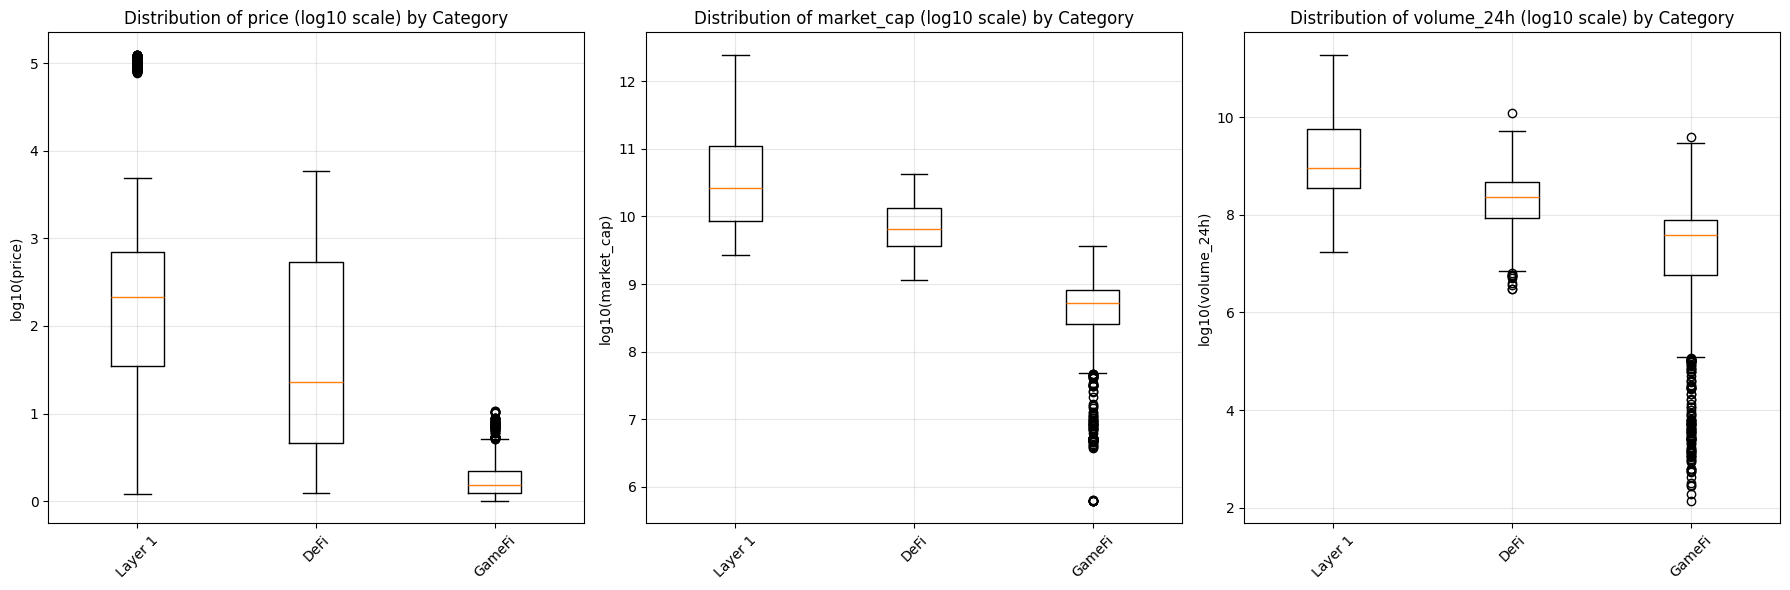

In [16]:

print("\n" + "="*80)
print("Step 3: Visualizing Outliers")
print("="*80)

# Create box plots for each category to visualize outliers
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
numeric_cols = ['price', 'market_cap', 'volume_24h']

for idx, col in enumerate(numeric_cols):
    ax = axes[idx]
    
    # Prepare data for boxplot (grouped by category)
    data_for_boxplot = []
    labels = []
    
    for category in all_historical_combined_filled['category'].unique():
        category_data = all_historical_combined_filled[
            all_historical_combined_filled['category'] == category
        ][col].dropna()
        # Use log transform for visualization due to large scale differences
        if col in ['price', 'market_cap', 'volume_24h']:
            category_data = np.log10(category_data + 1)  # +1 to handle zeros
        data_for_boxplot.append(category_data)
        labels.append(category)
    
    ax.boxplot(data_for_boxplot, labels=labels)
    ax.set_title(f'Distribution of {col} (log10 scale) by Category')
    ax.set_ylabel(f'log10({col})')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Both the IQR method and the boxplots indicate a substantial number of outliers in my dataset. However, I suspected that these detection results might be misleading for several reasons. First, the fact that the overall population follows a certain distribution does not contradict the possibility that specific subsets within it may deviate from that distribution. The selected coins represent only a small portion of the entire population, and the selection was based on objective criteria rather than random sampling.

To support this point, I printed the number of coins classified as outliers in Layer 1, as shown below. The result of IQR test was clearly not reliable as all bitcoin data was identified as outliers. For this reason, I decided not to remove observations solely based on the IQR detection results.

In [15]:
# Count the number of outliers for each coin (outside 3sigma interval)
print("\n" + "="*80)
print("Calculate the number of outliers for each coin")
print("="*80)

# Add outlier flag column to the dataframe
all_historical_combined_filled_with_outliers = all_historical_combined_filled.copy()
all_historical_combined_filled_with_outliers['is_outlier'] = combined_outlier_flags

# Count outliers for each coin (grouped by coin_name)
outlier_count_by_coin = all_historical_combined_filled_with_outliers.groupby('coin_name')['is_outlier'].sum().reset_index()
outlier_count_by_coin.columns = ['coin_name', 'outlier_count']

# Sort by outlier count in descending order
outlier_count_by_coin = outlier_count_by_coin.sort_values('outlier_count', ascending=False).head(4)

# Display results
print("\nThe number of outliers for each coin (descending):")
print("="*80)
print(outlier_count_by_coin.to_string(index=False))


Calculate the number of outliers for each coin

The number of outliers for each coin (descending):
        coin_name  outlier_count
          Bitcoin            365
    Wrapped stETH            302
         Ethereum            277
Lido Staked Ether            240


To further support my point, I presented the average value of each variable in the following table. The substantial differences across coins highlight the heterogeneity within the sample, which explains why relying solely on the IQR results to remove outliers would be inappropriate.

In [11]:
all_historical_combined_filled.groupby(['category','coin_name'])[['price','volume_24h']].mean()

price    volume_24h
category coin_name                                     
DeFi     Aave                  252.981987  5.113885e+08
         Chainlink              18.087853  9.614667e+08
         Dai                     0.999853  1.281805e+08
         Ethena                  0.523948  4.807791e+08
         Hyperliquid            31.793733  3.252725e+08
         Lido Staked Ether    3113.683063  6.953933e+07
         Uniswap                 8.708288  4.576988e+08
         Wrapped stETH        3751.714328  4.712476e+07
GameFi   ApeCoin                 0.676013  7.919262e+07
         Axie Infinity           3.237888  5.301157e+07
         Decentraland            0.325268  6.502330e+07
         FLOKI                   0.000100  1.857849e+08
         GALA                    0.019957  1.421945e+08
         Immutable               0.714144  5.390380e+07
         Legacy Token            1.750511  4.388408e+06
         The Sandbox             0.337123  1.373411e+08
         Undeads Games           1.035286  6.421672e+05
         WEMIX                   0.655388  5.364615e+06
Layer 1  BNB                   758.389709  1.639295e+09
         Bitcoin            102398.102077  4.799350e+10
         Bitcoin Cash          460.938863  3.379266e+08
         Cardano                 0.762872  1.308463e+09
         Ethereum             3116.881119  2.857555e+10
         Hyperliquid            31.793733  3.252725e+08
         Litecoin              102.282560  7.809501e+08
         Monero                276.019403  1.054964e+08
         Solana                176.548468  6.558060e+09
         TRON                    0.281267  1.108421e+09

## Feature engineering

I computed the daily changing rate for price, market_cap and volume data, illustrating the volitility of coin

In [ ]:
# Assume df has 'date', 'coin_name', 'price'
df = all_historical_combined_filled.copy()

# 1. Sort by coin_name and date
df = df.sort_values(by=['coin_name', 'date'])

# 2. Calculate log returns grouped by coin
df['price_log_return'] = df.groupby('coin_name')['price'].transform(lambda x: np.log(x) - np.log(x.shift(1)))
df['market_cap_log_return'] = df.groupby('coin_name')['market_cap'].transform(lambda x: np.log(x) - np.log(x.shift(1)))
df['volume_log_return'] = df.groupby('coin_name')['volume_24h'].transform(lambda x: np.log(x) - np.log(x.shift(1)))

# Fill first day returns with 0
df[['price_log_return', 'market_cap_log_return', 'volume_log_return']] = \
    df[['price_log_return', 'market_cap_log_return', 'volume_log_return']].fillna(0)


# Step 3: Perform exploratory analysis

## 3.1 An overview on sectors

### 3.1.1 Market share of each sector

I used market capitalization as an indicator of market share. As shown in the pie chart, Layer 1 dominates the cryptocurrency market, accounting for nearly 96%, whereas GameFi is the least prevalent sector, representing only 0.2%.

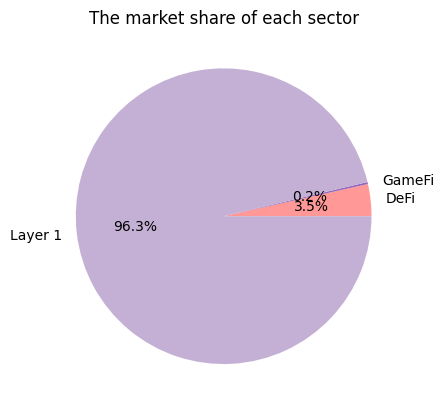

In [17]:
cate = (
    all_historical_combined_filled
    .groupby(['category'])['market_cap']
    .mean()
    .reset_index()
)
cate['percent'] = cate['market_cap']/sum(cate['market_cap'])*100
colors = plt.cm.tab20.colors[7:]  # 20 colors, cycle through
plt.pie(cate['percent'],labels=cate['category'],autopct='%1.1f%%',colors=colors)
plt.title('The market share of each sector')
plt.show()

### 3.1.2 The Market share distribution within the sector

The charts show that the characteristics of each sector differ substantially. Layer 1 is dominated by Bitcoin, which accounts for 75.5% of the sector’s market value, while the remaining coins together make up only 25%. In contrast, the top 10 coins share the GameFi market more evenly. For the DeFi sector, Lido and Wrapped hold a clear advantage over the other coins.

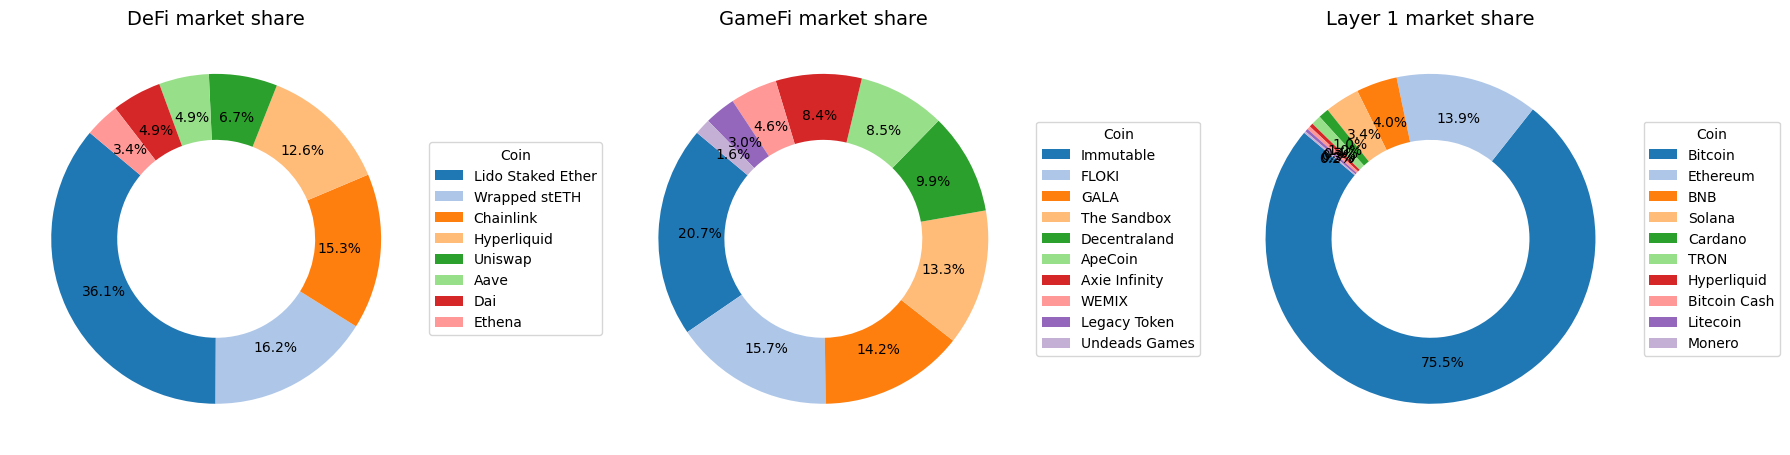

In [18]:
# calculate the portion of coin's capacity in a sector
# Average market cap for each coin
grouped = (
    all_historical_combined_filled
    .groupby(['category', 'coin_name'])['market_cap']
    .mean()
    .reset_index()
)

# Total market cap for each category
total_cap = (
    grouped.groupby('category')['market_cap']
    .sum()
    .reset_index()
    .rename(columns={'market_cap': 'total_market_cap'})
)

# Merge
grouped = grouped.merge(total_cap, on='category', how='left')

# Percentage
grouped['percent'] = grouped['market_cap'] / grouped['total_market_cap'] * 100


categories = grouped['category'].unique()

colors = plt.cm.tab20.colors

# Create subplot with one row and three columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, cat in zip(axes, categories):
    df_cat = grouped[grouped['category'] == cat].sort_values('market_cap', ascending=False)
    wedges, texts, autotexts = ax.pie(
        df_cat['market_cap'],
        autopct='%1.1f%%',         
        startangle=140,
        colors=colors,
        pctdistance=0.75,          
        wedgeprops={'width':0.4}  
    )
    
    # Set empty circle in ring center
    centre_circle = plt.Circle((0,0),0.55,fc='white')
    ax.add_artist(centre_circle)
    
    ax.set_title(f'{cat} market share', fontsize=14)
    
    # Add legend showing coin_name
    ax.legend(wedges, df_cat['coin_name'], title='Coin', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

Additionally, I offered insights into the concentration level of each sector from an economics perspective by using the Herfindahl–Hirschman Index (HHI) as an alternative measure. A higher HHI indicates a higher degree of market concentration. The results based on the HHI also show that Layer 1 is the most concentrated sector, while GameFi is the most dispersed.

In [ ]:
hhi = grouped.groupby('category')['percent'].apply(lambda x: (x**2).sum())
print(hhi)

category
DeFi       2057.832131
GameFi     1327.893918
Layer 1    5919.882060
Name: percent, dtype: float64


## 3.2 Investment strategy differenciation
The price distribution reflects different investment strategies in the market. Specifically, the distributions exhibit multiple peaks, each corresponding to a distinct group of investors. To address the long-tail nature of the data, I applied a log10 transformation and then used Kernel Density Estimation (KDE). The KDE method helps smooth the distribution and provides a clearer, continuous estimate of the underlying probability density, making it easier to identify structural patterns that might be obscured in the raw data.

The distribution of GameFi prices is more centralized, while the distributions of DeFi and Layer 1 are more dispersed. Among all sectors, Layer 1 has the widest price range.

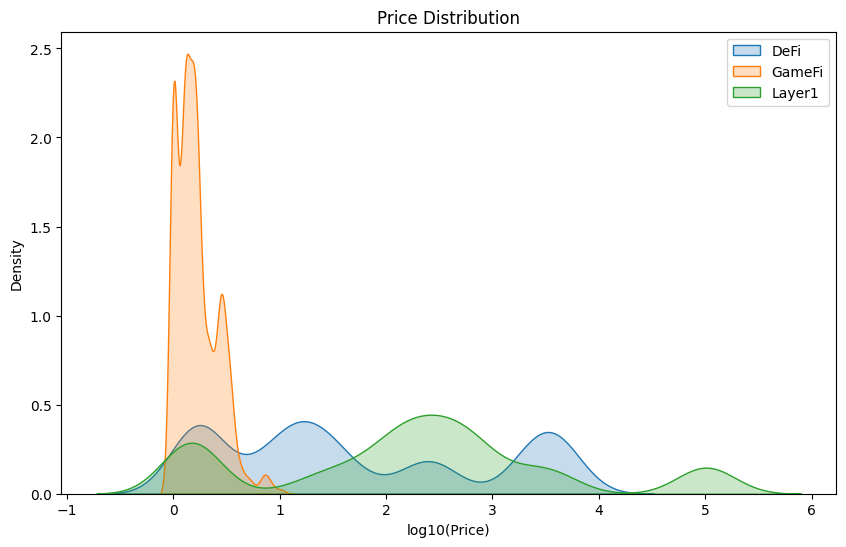

In [25]:
DeFi = all_historical_combined_filled[all_historical_combined_filled['category']=='DeFi']
GameFi = all_historical_combined_filled[all_historical_combined_filled['category']=='GameFi']
Layer1 = all_historical_combined_filled[all_historical_combined_filled['category']=='Layer 1']
plt.figure(figsize=(10,6))

# KDE plot
sns.kdeplot(np.log10(DeFi['price']+1), label='DeFi', fill=True) # To avoid negative price value, I plus 1 to each data
sns.kdeplot(np.log10(GameFi['price']+1), label='GameFi', fill=True)
sns.kdeplot(np.log10(Layer1['price']+1), label='Layer1', fill=True)

plt.xlabel('log10(Price)')
plt.ylabel('Density')
plt.title('Price Distribution')
plt.legend()
plt.show()

### 3.3 Correlation of Return Rates Between Coins
In this part, I used **scatter plots, correlation matrix and heatmap** to present the inter-coin correlation of return rates.

Scatter plots were used to examine the relationships between variables. In financial analysis, the rate of price change is often considered an indicator of returns. The charts show a strong positive correlation in returns across all sectors. In other words, when prices rise or fall in one sector, prices in the others tend to move in the same direction.

Furthermore, the correlation matrix indicates that all correlation coefficients exceed 0.8. Coefficients of this magnitude suggest a very strong linear relationship between sectors, implying that their price movements are highly synchronized and likely driven by similar underlying market forces.

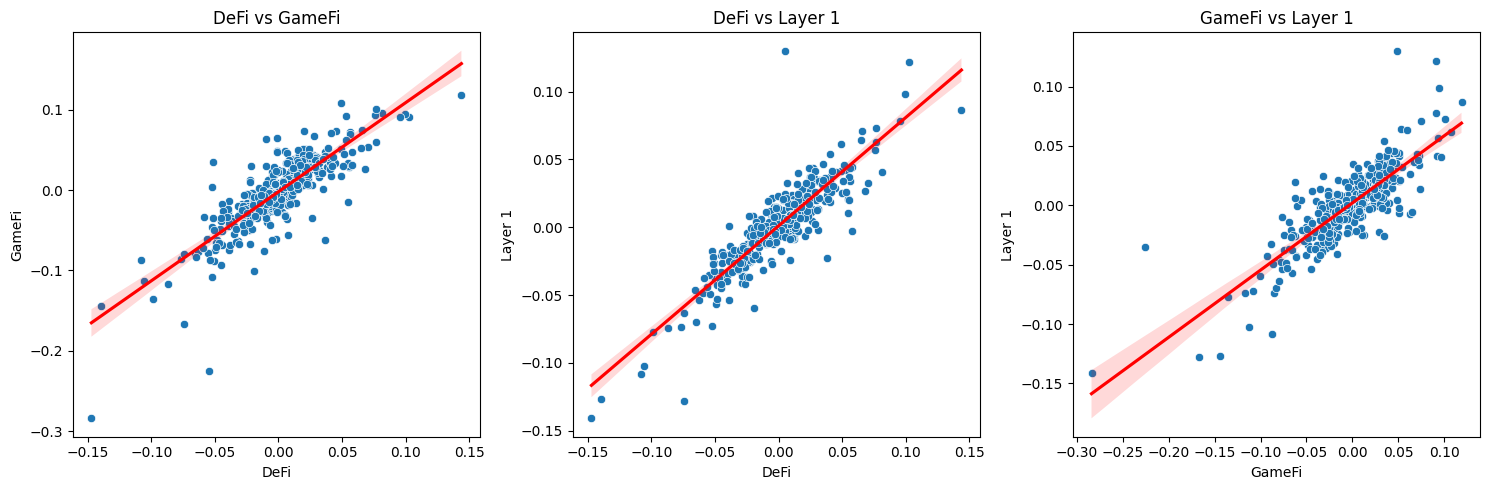

In [27]:
df = all_historical_combined_filled.copy()
df = df.sort_values(by=['coin_name','date'])

# Calculate log returns for each coin's price
df['price_log_return'] = df.groupby('coin_name')['price'].transform(lambda x: np.log(x) - np.log(x.shift(1)))
df["pct_change_7d"] = df.groupby('coin_name')["price"].pct_change(7) * 100
# Calculate average returns by category and date
avg_returns = df.groupby(['category','date'])['price_log_return'].mean().reset_index()

# Pivot table: each column represents a category, each row represents a date
pivot_df = avg_returns.pivot(index='date', columns='category', values='price_log_return')

# Fill missing values (optional, fill with 0 or forward fill)
pivot_df = pivot_df.fillna(0)

# Plot pairwise scatter plots for three categories
pairs = [('DeFi','GameFi'), ('DeFi','Layer 1'), ('GameFi','Layer 1')]
plt.figure(figsize=(15,5))
for i, (x_col, y_col) in enumerate(pairs, 1):
    plt.subplot(1,3,i)
    sns.scatterplot(x=pivot_df[x_col], y=pivot_df[y_col])
    sns.regplot(x=pivot_df[x_col], y=pivot_df[y_col], scatter=False, color='red')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'{x_col} vs {y_col}')

plt.tight_layout()
plt.show()

Correlation Matrix is:
category      DeFi    GameFi   Layer 1
category                              
DeFi      1.000000  0.837521  0.885847
GameFi    0.837521  1.000000  0.829896
Layer 1   0.885847  0.829896  1.000000
Here is the heat map:


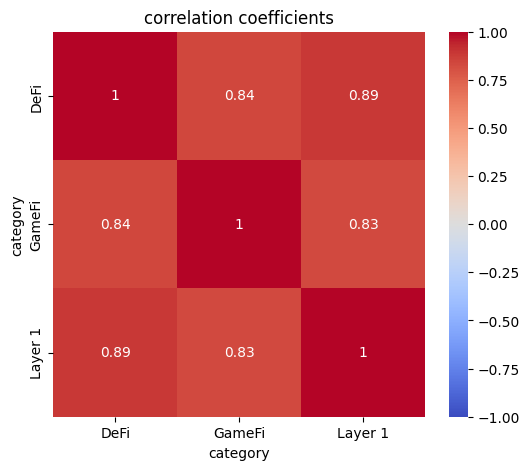

In [30]:
corr_matrix = pivot_df.corr()
print('Correlation Matrix is:')
print(corr_matrix)
print('='*80)
print('Here is the heat map:')
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("correlation coefficients")
plt.show()

# Step 4: Ask a question about your data

Based on the results of the previous Exploratory Data Analysis, this report finds that the price and trading volume of coins within the same category vary substantially. From an investor’s perspective, **I tried to figure out which sector was most profitable under a controlled level of risk**. Visualisation tools and Hypothesis test were both implemented in my report.

Worth mentioning, I replaced daily return rate by 7-day period return rate for robustness. 

### 4.1 Visualisation tool
**Risk Assessment:**

- Layer 1: Demonstrates moderate volatility, with a longer box and whiskers, implying some price fluctuations but overall moderate risk.

- DeFi: Shows relatively low volatility, with a median close to zero and a narrow box, suggesting stable prices and lower risk.

- GameFi: Exhibits the highest price volatility, with a negative median and a wide interquartile range, indicating large fluctuations and relatively high risk.

**Return Comparison:**

- Layer 1: The upper quartile is relatively high, indicating potential for higher returns under controlled risk.

- DeFi: The median is slightly above zero, but the upper quartile and maximum values are lower than Layer 1, suggesting moderate return potential.

- GameFi: The median return is negative, and although extreme positive outliers exist, the overall returns are low and accompanied by high risk, making it unsuitable for conservative investment.

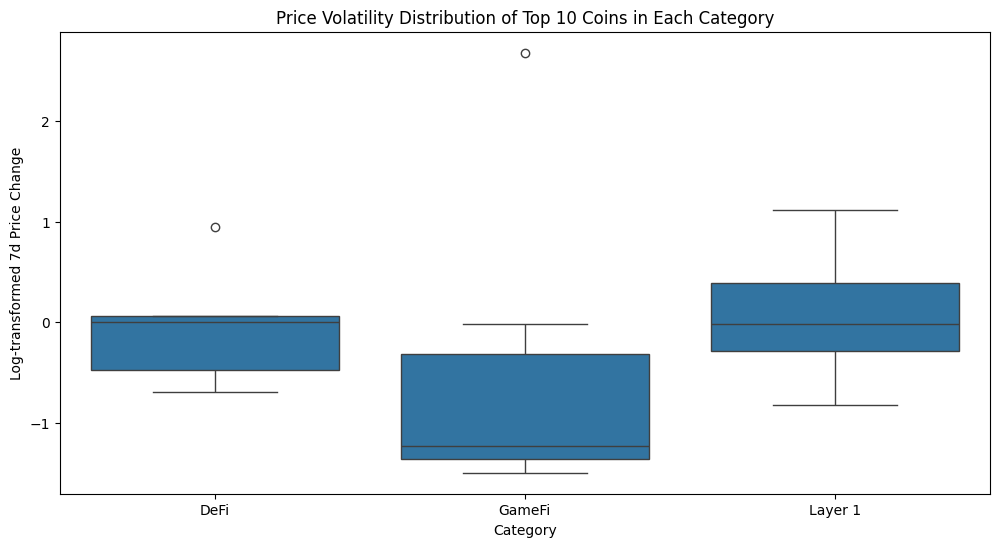

In [32]:
# Calculate mean pct_change_7d for each coin within each category
# Use groupby with as_index=False to avoid MultiIndex issues
category = (df.groupby(['category', 'coin_name'], as_index=False)['pct_change_7d']
            .mean())

# Handle log transformation: pct_change_7d can be negative, so we need to handle it carefully
# Since pct_change_7d is a percentage change, it can be negative
# We'll use log transformation on absolute values and preserve the sign
# Alternative: filter out negative values or use log1p
category['pct_change_7d_log'] = np.sign(category['pct_change_7d']) * np.log1p(np.abs(category['pct_change_7d']))

# Filter out infinite values that might occur from log transformation
category = category[np.isfinite(category['pct_change_7d_log'])]

plt.figure(figsize=(12,6))
sns.boxplot(
    data=category,
    x='category',
    y='pct_change_7d_log'
)
plt.title("Price Volatility Distribution of Top 10 Coins in Each Category")
plt.xlabel("Category")
plt.ylabel("Log-transformed 7d Price Change")
plt.show()


## Hypothesis Test

**Summary of Results：**

The Kruskal–Wallis test shows a significant difference in the mean 7-day log returns across the three categories (p = 0.022 < 0.05). The Levene’s test indicates that the variances are not significantly different (p = 0.592 > 0.05), suggesting that the level of volatility within each category is similar.

**Investment implication:**

Although different categories exhibit distinct average return patterns, the within-category variability remains comparable. This means that while the typical (average) performance differs across categories, their internal volatility profiles are largely alike.

In [24]:
group_data = [
    category[category['category'] == cat]['pct_change_7d_log'].dropna()
    for cat in ['DeFi','GameFi','Layer 1']
]

# Kruskal-Wallis test
h_stat, p_value = kruskal(*group_data)
print('Starting mean test')
print("Kruskal–Wallis H-stat:", h_stat)
print("p-value:", p_value)

# Variance test
stat, p_value = levene(*group_data)
print('\nStarting variance test')
print("Levene H-stat:", stat)
print("p-value:", p_value)

Starting mean test
Kruskal–Wallis H-stat: 7.6023399014778335
p-value: 0.022344614459518755

Starting variance test
Levene H-stat: 0.5359417175674622
p-value: 0.5916910991980165


# Step 5:  Summarise and write a conclusion
## 5.1 Summary
This comprehensive report of cryptocurrency market data across three major sectors — Layer 1, DeFi, and GameFi — provides valuable insights into market structure, investment characteristics, and risk-return profiles. The following conclusions summarize the key findings:

### 5.1.1 Data acquisition
This report acquire data via CoinGekco API(https://www.coingecko.com/)


### 5.1.2 Data Quality and Methodology

The analysis encountered challenges with outlier detection using the IQR method, as it identified all Bitcoin data as outliers—a clear indication that statistical outlier detection methods may be inappropriate for heterogeneous cryptocurrency datasets where natural scale differences exist. This finding highlights the importance of domain knowledge and careful interpretation of statistical results in financial data analysis.

## 5.2 Conclusions
### 5.2.1 Market Structure and Concentration

1. **Market Dominance**: Layer 1 cryptocurrencies dominate the market, accounting for approximately 96% of total market capitalization, while GameFi represents only 0.2%. This significant disparity reflects the foundational role of Layer 1 blockchains in the cryptocurrency ecosystem.

2. **Sector Concentration**: Analysis using the Herfindahl-Hirschman Index (HHI) reveals distinct concentration patterns:
   - **Layer 1** (HHI: 5919.88): Highly concentrated, with Bitcoin alone accounting for 75.5% of the sector's market value
   - **DeFi** (HHI: 2057.83): Moderately concentrated, with Lido and Wrapped stETH holding clear advantages
   - **GameFi** (HHI: 1327.89): Most dispersed, with more even distribution among top coins

3. **Price Distribution Patterns**: The price distributions exhibit multiple peaks, reflecting different investor groups and investment strategies. GameFi shows a more centralized distribution, while Layer 1 displays the widest price range, indicating greater diversity in coin valuations.

### 5.2.2 Market Interconnectedness

The correlation analysis reveals strong positive relationships between sectors, with all correlation coefficients exceeding 0.8:
- DeFi vs. Layer 1: 0.886
- DeFi vs. GameFi: 0.838
- GameFi vs. Layer 1: 0.830

This high correlation suggests that price movements across sectors are likely driven by common underlying market forces rather than sector-specific factors.

### 5.2.3 Risk-Return Analysis

The hypothesis testing results provide crucial insights for investment decision-making:

1. **Mean Returns**: The Kruskal-Wallis test indicates significant differences in average 7-day log returns across categories (p = 0.022 < 0.05), suggesting that different sectors offer distinct return profiles.

2. **Volatility**: The Levene's test shows no significant difference in variances (p = 0.592 > 0.05), indicating that volatility levels are comparable across sectors despite different average returns.

3. **Investment Implications**:
   - **Layer 1**: Demonstrates moderate volatility with potential for higher returns, making it suitable for investors seeking balanced risk-return profiles
   - **DeFi**: Shows relatively low volatility with stable prices, appealing to risk-averse investors
   - **GameFi**: Exhibits the highest volatility with negative median returns, making it less suitable for conservative investment strategies



## 5.3 Key Takeaways

1. **Market Structure**: The cryptocurrency market is highly concentrated in Layer 1 technologies, with Bitcoin playing a dominant role. This concentration may pose systemic risks but also reflects the foundational importance of Layer 1 blockchains.

2. **Investment Strategy**: For investors seeking profitability under controlled risk, Layer 1 appears to offer the most favorable risk-return profile, with moderate volatility and higher return potential compared to other sectors.

3. **Market Dynamics**: The high correlation between sectors suggests that diversification across cryptocurrency sectors may provide limited risk reduction, as all sectors tend to move together in response to broader market forces.

4. **Methodological Considerations**: The analysis demonstrates that standard statistical methods must be carefully applied and interpreted in the context of cryptocurrency markets, where natural heterogeneity and scale differences are expected features rather than anomalies.

## 5.4 Future improvement

This analysis is based on one year of historical data from the top 10 coins in each category, which represents a small, non-random sample of the broader cryptocurrency market. Future research could:
- Extend the analysis to include more coins and longer time periods
- Examine the impact of external factors, such as regulatory changes and technological developments, on sector performance. For example, we can construct a sentiment or attitude index using NLP techniques, and then analyze how news and regulatory updates affect cryptocurrency returns.

